In [1]:
import pandas as pd
import psycopg2
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from gensim.models.doc2vec import Doc2Vec
from faiss import read_index
import pickle
from gensim.utils import simple_preprocess
import numpy as np
from psycopg2.extras import execute_values
from xgboost import XGBRanker
from operator import itemgetter
import matplotlib.pyplot as plt
from multiprocessing import Pool

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

2024-01-10 20:34:25.715641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Divide countries

## Get hdi

In [2]:
# https://data.humdata.org/dataset/human-development-index-hdi
# https://hdr.undp.org/data-center/documentation-and-downloads

In [3]:
hdi_df = pd.read_excel("HDR21-22_Statistical_Annex_HDI_Table.xlsx", header=4)
hdi_df = hdi_df.rename(
    columns={"Unnamed: 1": "country", "Human Development Index (HDI) ": "value"}
)
hdi_df = hdi_df[["country", "value"]].dropna()[1:]
hdi_df["country"] = hdi_df["country"].str.lower()
hdi_df["value"] = pd.to_numeric(hdi_df["value"], errors="coerce")
hdi_df = hdi_df.set_index("country")

In [4]:
hdi_df.head(5)

,value
country,
switzerland,0.962
norway,0.961
iceland,0.959
"hong kong, china (sar)",0.952
australia,0.951


In [5]:
hdi_df[hdi_df["value"].isna()]

,value
country,
korea (democratic people's rep. of),NaN
monaco,NaN
nauru,NaN
somalia,NaN


In [6]:
hdi_df = hdi_df.dropna()

## Get user data

In [2]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)

In [11]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select id, country
                            from users
                            where country is not NULL
                            """
        )
        users = pd.DataFrame(cursor.fetchall(), columns=["user_id", "country"])
print(len(users))
users.head()

3941484


,user_id,country
0,22545,New Zealand
1,22621,Norway
2,22656,United Kingdom
3,6050,United Kingdom
4,519,United States


In [ ]:
# missing_countries = users[users["value"].isna()]["country"].unique()
# [(missing_country, in_df_name[0])
# for missing_country in missing_countries
# if (in_df_name:=hdi_df.index[hdi_df.index.str.contains(missing_country)].values).size>0]

# faroe islands HDI (2008)	0.950
# falkland islands HDI (2010)	0.874
# greenland HDI (2010)	0.786
# curacao HDI (2012)	0.811
# cayman islands HDI (2013)	0.984
# puerto rico HDI (2015)	0.845
# kosovo HDI (2016)	0.742
# guam HDI (2017) 0.901
# aland islands HDI (2017)	0.900
# gibraltar HDI (2018)	0.961
# macao HDI (2019) 0.922
# taiwan HDI (2021)	0.926

countries_to_replace = [
    ("russia", "russian federation"),
    ("tanzania", "tanzania (united republic of)"),
    ("hong kong", "hong kong, china (sar)"),
    ("moldova", "moldova (republic of)"),
    ("iran", "iran (islamic republic of)"),
    ("i̇ran", "iran (islamic republic of)"),
    ("syria", "syrian arab republic"),
    ("venezuela", "venezuela (bolivarian republic of)"),
    ("bolivia", "bolivia (plurinational state of)"),
    ("brunei", "brunei darussalam"),
    ("micronesia", "micronesia (federated states of)"),
    ("eswatini", "eswatini (kingdom of)"),
    ("turkey", "türkiye"),
    ("vietnam", "viet nam"),
    ("south korea", "korea (republic of)"),
    ("democratic republic of the congo", "congo (democratic republic of the)"),
    ("palestinian territory", "palestine, state of"),
    ("timor leste", "timor-leste"),
    ("ivory coast", "côte d'ivoire"),
    ("laos", "lao people's democratic republic"),
    ("republic of the congo", "congo"),
    ("i̇taly", "italy"),
    ("i̇raq", "iraq"),
]
users["country"] = users["country"].str.lower()
for original_country, replace_country in countries_to_replace:
    users["country"] = users["country"].str.replace(original_country, replace_country)

In [ ]:
users = users.join(hdi_df, on="country")
users.head()

In [ ]:
users[users["value"].isna()]["country"].unique()

In [ ]:
users = users[~users["value"].isna()]
len(users)

In [ ]:
sns.displot(users, x="value")

In [ ]:
users[users["country"] == "india"]["country"].count(), hdi_df.loc["india"]["value"]

In [ ]:
users[users["country"] == "united states"]["country"].count(), hdi_df.loc[
    "united states"
]["value"]

## Divide users

In [ ]:
HDI_THRESHOLD = 0.92
users["developed_country"] = (users["value"] > HDI_THRESHOLD).astype(int)
users["developed_country"].mean()

In [ ]:
users.to_csv("users_dev_country.csv", index=False)

In [22]:
users = pd.read_csv("users_dev_country.csv")

## Store results

In [ ]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """SELECT count(*)
            FROM information_schema.columns
            WHERE table_name = 'users'
            AND column_name = 'high_hdi'
        """
        )
        if cursor.fetchall()[0][0] == 0:
            cursor.execute("ALTER TABLE users ADD COLUMN high_hdi BOOLEAN;")
            print("Column created")
        else:
            print("Column already exists")

In [ ]:
with connection:
    with connection.cursor() as cursor:
        execute_values(
            cursor,
            """UPDATE users SET high_hdi = data.high_hdi::boolean
                FROM (VALUES %s) AS data (id, high_hdi)
                WHERE users.id = data.id""",
            [(user_id, high_hdi) for user_id, high_hdi in users[["user_id", "developed_country"]].values.tolist()],
            page_size=len(users),
        )

In [12]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """SELECT id, high_hdi
            FROM users
            WHERE high_hdi IS NOT NULL
            LIMIT 5
        """
        )
        users_sample = cursor.fetchall()
users_sample

[(22545, True), (22621, True), (22656, True), (6050, True), (519, True)]

In [13]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """SELECT count(*)
            FROM users
            WHERE high_hdi IS NOT NULL
        """
        )
        users_with_hdi_count = cursor.fetchall()
users_with_hdi_count[0][0], len(users)

(3872918, 3941484)

# Create dataset

In [3]:
question_embeddings_model = Doc2Vec.load("../text_model/python.doc")
question_transformer_model = tf.keras.models.load_model(
    "../../scripts/text_model/question_transformer_model"
)
index = read_index("../../scripts/text_model/users_imp.index")

In [4]:
with open("../../scripts/text_model/user_embeddings.pickle", "rb") as f:
    user_embedding, user_encoder = pickle.load(f)

In [7]:
MIN_ANSWERS = 3
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date >= '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 30000"""
        )
        posts = cursor.fetchall()

In [8]:
posts_vectors = []
posts_ids = []
for p_id, title, body in posts:
    posts_ids.append(p_id)
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_vectors.append(
        question_embeddings_model.infer_vector(simple_preprocess(post_text))
    )

KeyboardInterrupt: 

In [ ]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

In [ ]:
questions_transformed = question_transformer_model.predict(posts_vectors)
questions_transformed.shape

In [ ]:
qid2emb = {pid: emb for pid, emb in zip(posts_ids, questions_transformed)}

In [ ]:
distances, similar_questions = index.search(questions_transformed, 10000)
features_df = pd.DataFrame(
    list(zip(posts_ids, similar_questions)), columns=["q_id", "u_id"]
).explode("u_id")
features_df["u_id"] = features_df["u_id"].astype(int)

In [ ]:
features_df.to_csv("features_df.csv", index=False)

In [ ]:
features_df = pd.read_csv("features_df.csv")

In [ ]:
batch_size = 1000000

results = []
with connection:
    for batch_idx in range(len(features_df) // batch_size):
        with connection.cursor() as cursor:
            execute_values(
                cursor,
                """select q_id, u_id, q_a.score
                                    FROM (VALUES %s) AS base_questions (q_id, u_id)
                                    JOIN posts_19 q_a ON q_a.parent_id = q_id
                                    WHERE q_a.owner_user_id=u_id""",
                features_df[batch_idx * batch_size : (batch_idx + 1) * batch_size][
                    ["q_id", "u_id"]
                ].values.tolist(),
                page_size=batch_size,
            )
            results.extend(cursor.fetchall())
dataset = pd.DataFrame(results, columns=["q_id", "u_id", "score"])

In [ ]:
dataset.sort_values(by=["q_id"], inplace=True)
print(len(dataset))
dataset.head()

In [ ]:
full_dataset = features_df.merge(dataset, on=["q_id", "u_id"], how="left")

In [ ]:
full_dataset["feats"] = np.concatenate(
    (
        user_embedding[user_encoder.transform(full_dataset["u_id"])],
        np.array(itemgetter(*full_dataset["q_id"])(qid2emb)),
    ),
    axis=1,
).tolist()

In [ ]:
scored_dataset = full_dataset[~full_dataset["score"].isna()]
eval_feats = np.array(scored_dataset["feats"].values.tolist())
eval_scores = scored_dataset["score"]
eval_q_ids = scored_dataset["q_id"]

In [ ]:
full_dataset["is_answer"] = (~full_dataset["score"].isna()).astype(int)

In [ ]:
full_dataset = full_dataset.join(users.set_index("user_id"), on="u_id")

In [24]:
print(len(full_dataset))
full_dataset = full_dataset[~full_dataset["country"].isna()]
print(len(full_dataset))

39730071
25916129


# Calculate fairness

## Load LTR

In [25]:
ranker = XGBRanker()
ranker.load_model("../text_model/xgboost_ranker")

In [26]:
full_dataset["pscore"] = ranker.predict(np.array(full_dataset["feats"].values.tolist()))

In [27]:
full_dataset = full_dataset.sort_values(by=["q_id", "pscore"], ascending=False)

## P(is_answer | developed_country) = P(is_answer | ~developed_country) ?
!include condition by k

In [28]:
len(full_dataset[full_dataset["developed_country"] == 1]), len(
    full_dataset[full_dataset["developed_country"] == 0]
)

(12312175, 13603954)

In [29]:
full_dataset["is_answer"].mean()

0.00016198406791384623

In [30]:
full_dataset[full_dataset["developed_country"] == 1]["is_answer"].mean()

0.0001835581446819916

In [31]:
full_dataset[full_dataset["developed_country"] == 0]["is_answer"].mean()

0.00014245858226218642

In [32]:
full_dataset.to_csv("full_dataset.csv", index=False)

In [4]:
full_dataset = pd.read_csv("full_dataset.csv")

### In top k

In [3]:
top_k = [20, 200, 2000, 4000, 6000, 7000, 10000]


def calculate_top_k_p(k):
    top_df = full_dataset.groupby("q_id", group_keys=False)[
        ["developed_country", "is_answer", "q_id"]
    ].apply(lambda x: x.head(k))
    return (
        top_df["is_answer"].mean() * 100,
        top_df[top_df["developed_country"] == 1]["is_answer"].mean(),
        top_df[top_df["developed_country"] == 0]["is_answer"].mean(),
    )


with Pool(8) as p:
    p_is_answer_cond = p.map(calculate_top_k_p, top_k)
p_is_answer, p_is_answer_dev, p_is_answer_no_dev = zip(*p_is_answer_cond)

In [4]:
p_is_answer_dev, p_is_answer_no_dev

((0.0012616600136507476,
  0.0009936618723024907,
  0.00032410522844889943,
  0.00022167346964685868,
  0.00018688894365359652,
  0.0001835581446819916,
  0.0001835581446819916),
 (0.0007071453826620809,
  0.0008664863976574988,
  0.00031469289470064933,
  0.0002047270617736774,
  0.00015242215962150992,
  0.00014245858226218642,
  0.00014245858226218642))

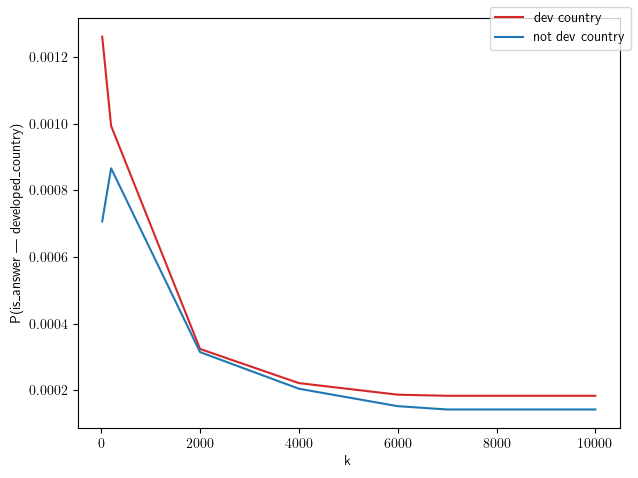

In [5]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel(" P(is_answer | developed_country)")
ax1.plot(top_k, p_is_answer_dev, color=color, label="dev country")
ax1.plot(top_k, p_is_answer_no_dev, color="tab:blue", label="not dev country")

fig.tight_layout()
fig.legend()
plt.show()

In [11]:
top_k = list(range(1, 100, 3))

with Pool(7) as p:
    p_is_answer_cond = p.map(calculate_top_k_p, top_k)
p_is_answer, p_is_answer_dev, p_is_answer_no_dev = zip(*p_is_answer_cond)

In [6]:
top_k = list(range(1, 100))


def calculate_top_k_p(k):
    top_df = full_dataset.groupby("q_id", group_keys=False)[
        ["developed_country", "is_answer", "q_id"]
    ].apply(lambda x: x.head(k))
    return (
        top_df[top_df["developed_country"] == 1]["is_answer"].mean(),
        top_df[top_df["developed_country"] == 0]["is_answer"].mean(),
    )


with Pool(8) as p:
    p_is_answer_cond = p.map(calculate_top_k_p, top_k)
p_is_answer_dev, p_is_answer_no_dev = zip(*p_is_answer_cond)

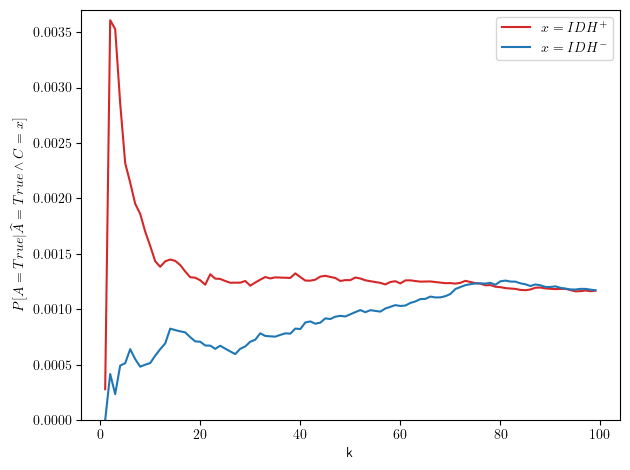

In [7]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[A=True|\widehat{A}=True \land C=x]$")
ax1.plot(top_k, p_is_answer_dev, color=color, label="$x=IDH^+$")
ax1.plot(top_k, p_is_answer_no_dev, color="tab:blue", label="$x=IDH^-$")
ax1.set_ylim([0, 0.0037])
ax1.legend()

fig.tight_layout()
fig.savefig("prec_mean_before.pdf")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


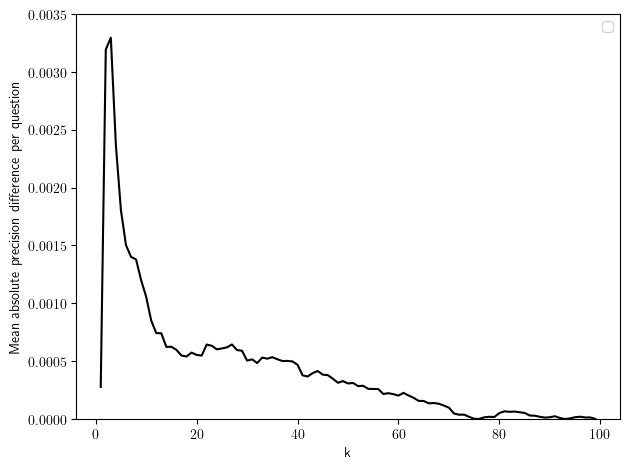

In [9]:
fig, ax1 = plt.subplots()

mean_prec_difference = [np.absolute(k_dev_mean_prec - k_no_dev_mean_prec)
                             for k_dev_mean_prec, k_no_dev_mean_prec
                             in zip(p_is_answer_dev, p_is_answer_no_dev)]
color = "black"
ax1.set_xlabel("k")
ax1.set_ylabel("Mean absolute precision difference per question")
ax1.plot(top_k, mean_prec_difference, color=color)
ax1.set_ylim(0, 0.0035)

fig.savefig("prec_difference_before.pdf")
fig.tight_layout()
ax1.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


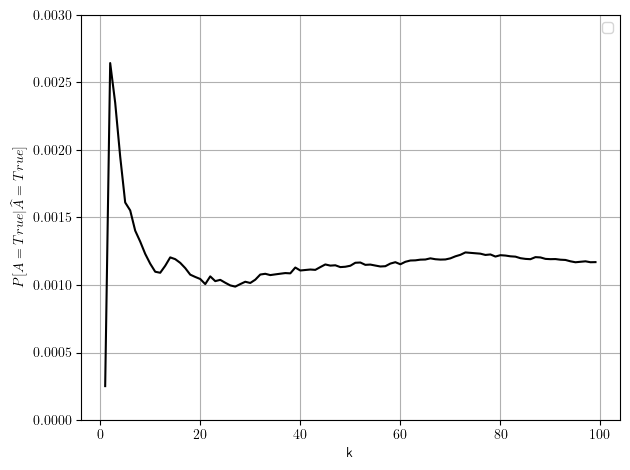

In [5]:
top_k = list(range(1, 100))

def calculate_top_k_p_all(k):
    top_df = full_dataset.groupby("q_id", group_keys=False)[
        ["developed_country", "is_answer", "q_id"]
    ].apply(lambda x: x.head(k))
    return top_df["is_answer"].mean()


with Pool(8) as p:
    p_is_answer_all = p.map(calculate_top_k_p_all, top_k)

fig, ax1 = plt.subplots()

color = "black"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[A=True|\widehat{A}=True]$")
ax1.plot(top_k, p_is_answer_all, color=color)
ax1.set_ylim([0, 0.003])
ax1.legend()
ax1.grid()

fig.tight_layout()
fig.savefig("prec_mean_before_all.pdf")
plt.show()

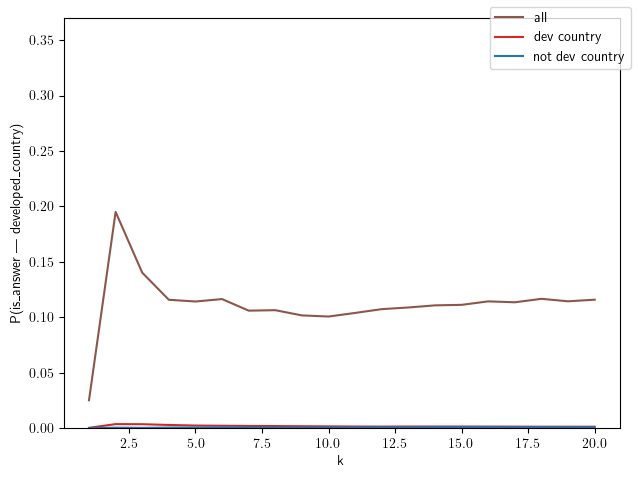

In [15]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel(" P(is_answer | developed_country)")
ax1.plot(top_k[:20], p_is_answer[:20], color="tab:brown", label="all")
ax1.plot(top_k[:20], p_is_answer_dev[:20], color=color, label="dev country")
ax1.plot(top_k[:20], p_is_answer_no_dev[:20], color="tab:blue", label="not dev country")
ax1.set_ylim([0, 0.37])

fig.tight_layout()
fig.legend()
plt.show()

## Proportion of developed countries in k

In [3]:
top_k = [20, 100, 1000, 2000, 4000, 6000, 7000, 10000]

mean_proportion = []
# process pool
for k in top_k:
    mean_proportion.append(
        full_dataset.groupby("q_id")[["developed_country", "q_id"]]
        .apply(
            lambda x: x.head(k)["developed_country"].mean()
            if len(x.head(k)) == k
            else -1
        )
        .loc[lambda x: x >= 0]
        .mean()
    )

In [4]:
mean_proportion

[0.6084696702743518,
 0.593559023408004,
 0.5319642587465392,
 0.5141068462119305,
 0.4956235841933048,
 0.47900604077523284,
 nan,
 nan]

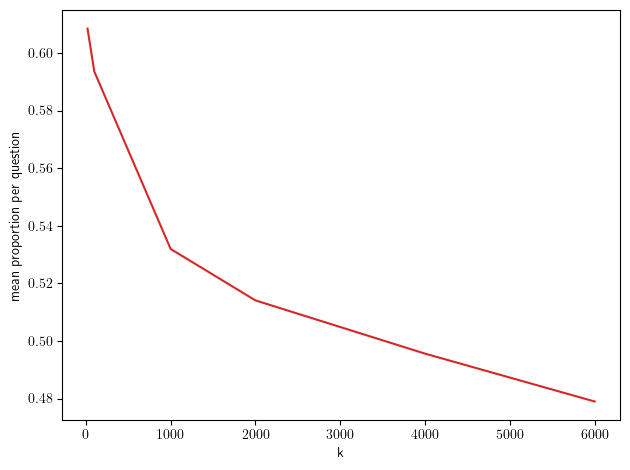

In [5]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean proportion per question")
ax1.plot(top_k, mean_proportion, color=color)

fig.tight_layout()
plt.show()

### Top 400

In [7]:
top_k = list(range(351))

mean_proportion = []
# process pool
for k in top_k:
    mean_proportion.append(
        full_dataset.groupby("q_id")[["developed_country", "q_id"]]
        .apply(
            lambda x: x.head(k)["developed_country"].mean()
            if len(x.head(k)) == k
            else -1
        )
        .loc[lambda x: x >= 0]
        .mean()
    )


KeyboardInterrupt



In [ ]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean proportion per question")
ax1.plot(top_k, mean_proportion, color=color)

fig.tight_layout()
plt.show()

In [ ]:
mean_proportion[:10]

In [ ]:
# cambiar por xlxs
# Leer fair, probar lib,metrica y algoritmo
# identificar 1st fairness fairness and machine learning hardt
# agregar al plot P(is_answer )

In [ ]:
# granularidad ne las primeras 400
# correr la libreria

In [ ]:
full_dataset.head()

In [ ]:
df_for_fair = full_dataset[full_dataset["q_id"] == 74681417][
    ["u_id", "pscore", "developed_country"]
].head(350)
df_for_fair.head()

In [ ]:
df_for_fair.to_csv("df_for_fair_74681417.csv", index=False)

In [ ]:
df_for_fair_complete = (
    full_dataset[["q_id", "u_id", "pscore", "developed_country"]]
    .groupby("q_id")
    .apply(lambda x: x.head(350))
    .reset_index(drop=True)
)
df_for_fair_complete.head()

In [ ]:
df_for_fair_complete.to_csv("df_for_fair_complete.csv", index=False)